In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:53268")
client

Client Scheduler: tcp://127.0.0.1:53268 Dashboard: http://127.0.0.1:36562/status,Cluster Workers: 8 Cores: 40 Memory: 169.33 GB


In [8]:
import numpy as np
import xarray as xr
import pandas as pd
from dask.diagnostics import ProgressBar
import os.path as op
import os
import xrft
import gsw
import time
from xhistogram.xarray import histogram as xhist
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from MITgcmutils import jmd95
from fastjmd95 import rho as densjmd95
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
ySstart = -15
yNstart = 10
yend = 50
year = 1964

# Try out Dec. 27-31, 1963

In [5]:
xchunk = 250
# ychunk = 400
nmembs = range(24,36)
ystart = ySstart

for nmemb in nmembs:
    if nmemb == 24:
        dsnap = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                            % (nmemb,1963)), 
                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                    prefix=['diag_ocnSnap',
    #                                         'diag_Tbgt2D','diag_Tbgt3D',
    #                                         'diag_Sbgt2D','diag_Sbgt3D'
                                           ], delta_t=2e2,
    #                                 iters=range(943920-2160,943920+2160,2160),
    #                                 iters=943920, 
    #                                 chunks={'XC':xchunk,'XG':xchunk}
                                   ).chunk({'XC':xchunk,'XG':xchunk})
    else:
        dsnap = xr.concat([dsnap, 
                               open_mdsdataset(op.join(ddir,
                                                       'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                       % (nmemb,1963)), 
                                               grid_dir=op.join(ddir,
                                                                'grid_chaO/gridMIT_update1/'),
                                               prefix=['diag_ocnSnap',
#                                                        'diag_Tbgt2D','diag_Tbgt3D',
#                                                        'diag_Sbgt2D','diag_Sbgt3D'
                                                      ], delta_t=2e2,
#                                                iters=range(943920-2160,943920+2160,2160),
#                                                iters=943920, 
#                                                chunks={'XC':xchunk,'XG':xchunk}
                                              ).chunk({'XC':xchunk,'XG':xchunk})],
                              dim='nmemb')
dsnap.coords['nmemb'] = ('nmemb',range(12))
dsnap = dsnap.chunk({'nmemb':1})
    
grid = Grid(dsnap, periodic=['X'])
    
Vol = (dsnap.Depth * dsnap.rA).where(dsnap.maskInC!=0.).sel(YC=slice(ystart-12**-1,
                                                                         yend+2*12**-1)
                                                               ).sum(skipna=True)
if op.exists(op.join(savedir,'IC_temperature-bias_%2dN-%2dN.nc'
                     % (np.abs(ystart),yend))):
    dHT_0 = xr.open_dataset(op.join(savedir,'IC_temperature-bias_%2dN-%2dN.nc'
                                        % (np.abs(ystart),yend))).dHT0  
else:
    HTb_0 = (dsnap.THETA.isel(time=0).where(dsnap.maskC!=0.
                                                   ).mean('nmemb',skipna=True)
                     * dsnap.hFacC * dsnap.drF * dsnap.rA).sel(YC=slice(ystart-12**-1,
                                                                        yend+2*12**-1)
                                                              ).sum(['Z','YC','XC'],skipna=True)
    HT_0 = (dsnap.THETA.isel(time=0).where(dsnap.maskC!=0.)
                    * dsnap.hFacC * dsnap.drF * dsnap.rA).sel(YC=slice(ystart-12**-1,
                                                                       yend+2*12**-1)
                                                             ).sum(['Z','YC','XC'],skipna=True)
    dHT_0 = ((HT_0 - HTb_0) * Vol**-1).compute()
    dHT_0.to_dataset(name='dHT0').to_netcdf(op.join(savedir,
                                                       'IC_temperature-bias_%2dN-%2dN.nc'
                                                    % (np.abs(ystart),yend)))
if op.exists(op.join(savedir,'IC_salinity-bias_%2dS-%2dN.nc'
                     % (np.abs(ystart),yend))):
    dHS_0 = xr.open_dataset(op.join(savedir,'IC_salinity-bias_%2dS-%2dN.nc'
                                        % (np.abs(ystart),yend))).dHS0  
else:
    HSb_0 = (dsnap.SALT.isel(time=0).where(dsnap.maskC!=0.
                                          ).mean('nmemb',skipna=True)
             * dsnap.hFacC * dsnap.drF * dsnap.rA).sel(YC=slice(ystart-12**-1,
                                                                yend+2*12**-1)
                                                      ).sum(['Z','YC','XC'],skipna=True)
    HS_0 = (dsnap.SALT.isel(time=0).where(dsnap.maskC!=0.)
            * dsnap.hFacC * dsnap.drF * dsnap.rA).sel(YC=slice(ystart-12**-1,
                                                               yend+2*12**-1)
                                                     ).sum(['Z','YC','XC'],skipna=True)
    dHS_0 = ((HS_0 - HSb_0) * Vol**-1).compute()
    dHS_0.to_dataset(name='dHS0').to_netcdf(op.join(savedir,
                                                    'IC_salinity-bias_%2dS-%2dN.nc'
                                                    % (np.abs(ystart),yend)))
print(dHT_0, dHS_0)

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option

<xarray.DataArray (nmemb: 12)>
array([ 0.06959205,  0.06664602,  0.05075374,  0.03453116,  0.02120838,
        0.00582232, -0.00973378, -0.02350871, -0.03641186, -0.0484491 ,
       -0.05940416, -0.07103666], dtype=float32)
Coordinates:
    iter     int64 788400
    time     float64 1.577e+08
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11 <xarray.DataArray 'dHS0' (nmemb: 12)>
array([ 3.575205e-02,  2.718861e-02,  1.916430e-02,  1.218378e-02,
        5.864639e-03, -8.149686e-05, -5.566862e-03, -1.061967e-02,
       -1.525245e-02, -1.931475e-02, -2.292256e-02, -2.635483e-02],
      dtype=float32)
Coordinates:
    iter     int64 ...
    time     timedelta64[ns] ...
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11


In [6]:
xchunk = 250
ychunk = 400
nmembs = range(24,36)
ystart = ySstart

for yy in range(1963,1968):
    for nmemb in nmembs:
        if nmemb == 24:
            dsnap = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                            % (nmemb,yy)), 
                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                    prefix=['diag_ocnSnap',
    #                                         'diag_Tbgt2D','diag_Tbgt3D',
    #                                         'diag_Sbgt2D','diag_Sbgt3D'
                                           ], delta_t=2e2,
    #                                 iters=range(943920-2160,943920+2160,2160),
    #                                 iters=943920, 
    #                                 chunks={'XC':xchunk,'XG':xchunk}
                                   ).chunk({'XC':xchunk,'XG':xchunk})
        else:
            dsnap = xr.concat([dsnap, 
                               open_mdsdataset(op.join(ddir,
                                                       'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                       % (nmemb,yy)), 
                                               grid_dir=op.join(ddir,
                                                                'grid_chaO/gridMIT_update1/'),
                                               prefix=['diag_ocnSnap',
#                                                        'diag_Tbgt2D','diag_Tbgt3D',
#                                                        'diag_Sbgt2D','diag_Sbgt3D'
                                                      ], delta_t=2e2,
#                                                iters=range(943920-2160,943920+2160,2160),
#                                                iters=943920, 
#                                                chunks={'XC':xchunk,'XG':xchunk}
                                              ).chunk({'XC':xchunk,'XG':xchunk})],
                              dim='nmemb')
    dsnap.coords['nmemb'] = ('nmemb',range(12))
    dsnap = dsnap.chunk({'nmemb':1})
    
    grid = Grid(dsnap, periodic=['X'])
    
    Vol = (dsnap.Depth * dsnap.rA).where(dsnap.maskInC!=0.).sel(YC=slice(ystart-12**-1,
                                                                         yend+2*12**-1)
                                                               ).sum(skipna=True)
    dHT_0 = xr.open_dataset(op.join(savedir,'IC_temperature-bias_%2dS-%2dN.nc'
                                        % (np.abs(ystart),yend))).dHT0
    dHS_0 = xr.open_dataset(op.join(savedir,'IC_salinity-bias_%2dS-%2dN.nc'
                                        % (np.abs(ystart),yend))).dHS0
    
    HT = (((dsnap.THETA.where(dsnap.maskC!=0.) - dHT_0
           ) * dsnap.hFacC * dsnap.drF * dsnap.rA
          ).sel(Z=slice(None,None),
                YC=slice(ystart-12**-1,yend+2*12**-1)).sum(['Z','YC','XC'],skipna=True) 
          * Vol**-1
         ).compute()
#     HT = (((dsnap.THETA.where(dsnap.maskC!=0.)
#            ) * dsnap.hFacC * dsnap.drF * dsnap.rA
#           ).sel(Z=slice(None,None),
#                 YC=slice(ystart-12**-1,yend+2*12**-1)).sum(['Z','YC','XC'],skipna=True) 
#           * Vol**-1
#          ).compute()
#     HT = (((dsnap.THETA.where(dsnap.maskC!=0.) - dHT_0
#            ) * dsnap.hFacC * dsnap.drF * dsnap.rA
#           ).sel(Z=slice(None,-2000),YC=slice(ystart-12**-1,
#                                              yend+2*12**-1)).sum(['Z','YC','XC'],skipna=True) 
#           * (dsnap.hFacC * dsnap.drF * dsnap.rA
#             ).where(dsnap.maskC!=0.).sel(Z=slice(None,-2000),
#                                          YC=slice(ystart-12**-1,
#                                                   yend+2*12**-1)).sum(skipna=True)**-1
#          ).compute()
    HT.to_dataset(name='Htheta').to_netcdf(op.join(savedir,
                                                   '%4d/Htheta_adjusted_%4d.nc' 
                                                   % (yy,yy)))
    
    HS = (((dsnap.SALT.where(dsnap.maskC!=0.)
           ) * dsnap.hFacC * dsnap.drF * dsnap.rA
          ).sel(Z=slice(None,None),
                YC=slice(ystart-12**-1,yend+2*12**-1)).sum(['Z','YC','XC'],skipna=True) 
          * Vol**-1
         ).compute()
    HS.to_dataset(name='Hsalt').to_netcdf(op.join(savedir,
                                                   '%4d/Hsalt_%4d.nc' 
                                                   % (yy,yy)))
    del HS
    HS = (((dsnap.SALT.where(dsnap.maskC!=0.) - dHS_0
           ) * dsnap.hFacC * dsnap.drF * dsnap.rA
          ).sel(Z=slice(None,None),
                YC=slice(ystart-12**-1,yend+2*12**-1)).sum(['Z','YC','XC'],skipna=True) 
          * Vol**-1
         ).compute()
    HS.to_dataset(name='Hsalt').to_netcdf(op.join(savedir,
                                                  '%4d/Hsalt_adjusted_%4d.nc' 
                                                  % (yy,yy)))
    del HS
    print('Hsalt done.')
    
#     HKE = ((.5*(grid.interp(dsnap.UVEL.where(dsnap.maskW!=0.)**2,'X') 
#                 + grid.interp(dsnap.VVEL.where(dsnap.maskS!=0.)**2,'Y',boundary='fill')
#                ) * dsnap.hFacC * dsnap.drF * dsnap.rA
#            ).sel(Z=slice(None,None),
#                  YC=slice(ystart-12**-1,yend+2*12**-1)).sum(['Z','YC','XC'],skipna=True) 
#            * Vol**-1
#           ).compute()
#     HKE = ((.5*(grid.interp(dsnap.UVEL.where(dsnap.maskW!=0.)**2,'X') 
#                 + grid.interp(dsnap.VVEL.where(dsnap.maskS!=0.)**2,'Y',boundary='fill')
#                ) * dsnap.hFacC * dsnap.drF * dsnap.rA
#            ).sel(Z=slice(None,-2000),
#                  YC=slice(ystart-12**-1,yend+2*12**-1)).sum(['Z','YC','XC'],skipna=True) 
#            * (dsnap.hFacC * dsnap.drF * dsnap.rA
#              ).where(dsnap.maskC!=0.).sel(Z=slice(None,-2000),
#                                           YC=slice(ystart-12**-1,
#                                                    yend+2*12**-1)).sum(skipna=True)**-1
#           ).compute()
#     HKE.to_dataset(name='HKE').to_netcdf(op.join(savedir,'%4d/HKE_%4d.nc'
#                                                  % (yy,yy)))
#     del HKE
#     print('HKE done.')
    dsnap.close()
    print(yy)

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option

Hsalt done.
1963


/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option

Hsalt done.
1964


/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option

Hsalt done.
1965


/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option

Hsalt done.
1966


/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option

Hsalt done.
1967


In [7]:
dsbar = dsnap.mean('nmemb')
dsbar

<xarray.Dataset>
Dimensions:   (XC: 1000, XG: 1000, YC: 900, YG: 900, Z: 46, Zl: 46, Zp1: 47, Zu: 46)
Coordinates:
    dxG       (YG, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    drC       (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    rAs       (YG, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    iter      int64 dask.array<chunksize=(), meta=np.ndarray>
    maskInS   (YG, XC) bool dask.array<chunksize=(900, 250), meta=np.ndarray>
    rAz       (YG, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    rAw       (YC, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    dxC       (YC, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    hFacW     (Z, YC, XG) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    maskInC   (YC, XC) bool dask.array<chunksize=(900, 250), meta=np.ndarray>
    maskW     (Z, YC, XG) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    dyC       (YG, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    hFacC     (Z, YC, XC) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    hFacS     (Z, YG, XC) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    PHrefF    (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    dyG       (YC, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    Depth     (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    time      float64 1.888e+08
    drF       (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskS     (Z, YG, XC) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    PHrefC    (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskC     (Z, YC, XC) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    maskInW   (YC, XG) bool dask.array<chunksize=(900, 250), meta=np.ndarray>
    rA        (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
  * YC        (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XG        (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * YG        (YG) >f4 -19.9583 -19.874968 -19.791634 ... 54.875034 54.95837
  * Zu        (Zu) >f4 -6.0935454 -12.814552 -19.91338 ... -5749.9097 -6000.3726
  * Zl        (Zl) >f4 0.0 -6.0935454 -12.814552 ... -5499.9937 -5749.9097
  * XC        (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * Zp1       (Zp1) >f4 0.0 -6.0935454 -12.814552 ... -5749.9097 -6000.3726
  * Z         (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
Data variables:
    THETA     (Z, YC, XC) float32 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    SALT      (Z, YC, XC) float32 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    UVEL      (Z, YC, XG) float32 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    VVEL      (Z, YG, XC) float32 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    WVEL      (Zl, YC, XC) float32 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    PHIHYD    (Z, YC, XC) float32 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    TOTTTEND  (Z, YC, XC) float32 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    ADVr_TH   (Zl, YC, XC) float32 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    ADVx_TH   (Z, YC, XG) float32 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    ADVy_TH   (Z, YG, XC) float32 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    Diss_TH   (Z, YC, XC) float32 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    TFLUX     (YC, XC) float32 dask.array<chunksize=(900, 250), meta=np.ndarray>
    oceQsw    (YC, XC) float32 dask.array<chunksize=(900, 250), meta=np.ndarray>
    WTHMASS   (YC, XC) float32 dask.array<chunksize=(900, 250), meta=np.ndarray>
    SFLUX     (YC, XC) float32 dask.array<chunksize=(900, 250), meta=np.ndarray>
    oceFWflx  (YC, XC) float32 dask.array<chunksize=(900, 250), meta=np.ndarray>
    WSLTMASS  (YC, XC) float32 dask.array<chunksize=(900, 250), meta=np.ndarray

In [ ]:
HT = (((dsnap.THETA.where(dsnap.maskC!=0.).sel(YC=slice(ystart-12**-1,yend+2*12**-1))
        * dsnap.hFacC * dsnap.drF
       ).sel(Z=slice(None,-2100)).sum('Z',skipna=True) 
       * np.abs(dsnap.Z.sel(Z=-2054,method='nearest'))**-1 * dsnap.rA
      ).where(dsnap.maskInC!=0.).sum(['YC','XC'],skipna=True)
      * dsnap.rA.where(dsnap.maskInC!=0.).sum(['YC','XC'],skipna=True)**-1
     ).compute()

HT.to_dataset(name='Htheta').to_netcdf(op.join(savedir,'%4d/Htheta_0-2000m_%4d.nc' 
                                               % (year,year)))

In [14]:
# HKE = xr.ones_like(dsnap.time) * np.nan

# for tt in range(len(KE.time)):
#     tmp = (((.5*(grid.interp(dsnap.UVEL**2,'X') 
#                  + grid.interp(dsnap.VVEL**2,'Y',boundary='fill')).mean('nmemb')
#              * dsnap.drF).sum('Z') 
#             * ds.Depth**-1 * ds.rA).where(ds.maskInC!=0.).sum(['YC','XC'],skipna=True)
#            * ds.rA.where(ds.maskInC!=0.).sum(['YC','XC'],skipna=True)**-1
#           ).compute()
#     HKE[tt] = tmp.data
#     del tmp
#     print(tt)
#     time.sleep(8)
HKE = (((.5*(grid.interp(dsnap.UVEL.where(dsnap.maskW!=0.)**2,'X') 
             + grid.interp(dsnap.VVEL.where(dsnap.maskS!=0.)**2,'Y',boundary='fill')
            ).sel(YC=slice(ystart-12**-1,yend+2*12**-1))
        * dsnap.hFacC * dsnap.drF).sel(Z=slice(None,-2100)).sum('Z',skipna=True) 
        * np.abs(dsnap.Z.sel(Z=-2054,method='nearest'))**-1 * dsnap.rA
       ).where(dsnap.maskInC!=0.).sum(['YC','XC'],skipna=True)
       * dsnap.rA.where(dsnap.maskInC!=0.).sum(['YC','XC'],skipna=True)**-1
      ).compute()
    
HKE.to_dataset(name='HKE').to_netcdf(op.join(savedir,'%4d/HKE_0-2000m_%4d.nc'
                                             % (year,year)))

KeyboardInterrupt: 

In [7]:
for yy in range(1963,1968):
    if yy == 1963:
        HT = xr.open_dataset(op.join(savedir,'%4d/Htheta_adjusted_%4d.nc' 
                                     % (yy,yy))).Htheta
        HS = xr.open_dataset(op.join(savedir,'%4d/Hsalt_adjusted_%4d.nc' 
                                     % (yy,yy))).Hsalt
        HKE = xr.open_dataset(op.join(savedir,'%4d/HKE_%4d.nc' % (yy,yy))).HKE
    else:
        HT = xr.concat([HT,xr.open_dataset(op.join(savedir,'%4d/Htheta_adjusted_%4d.nc' 
                                                   % (yy,yy))).Htheta],
                       dim='time')
        HS = xr.concat([HS,xr.open_dataset(op.join(savedir,'%4d/Hsalt_adjusted_%4d.nc' 
                                                   % (yy,yy))).Hsalt],
                       dim='time')
        HKE = xr.concat([HKE,xr.open_dataset(op.join(savedir,'%4d/HKE_%4d.nc' 
                                                     % (yy,yy))).HKE],
                        dim='time')
HKE

<xarray.DataArray 'HKE' (nmemb: 12, time: 365)>
array([[0.00328799, 0.00321779, 0.00315997, ..., 0.00351007, 0.00353898,
        0.00342954],
       [0.00332231, 0.00329964, 0.00328875, ..., 0.00351017, 0.00353503,
        0.00346702],
       [0.00314033, 0.00305418, 0.00302637, ..., 0.00376809, 0.00377554,
        0.00370216],
       ...,
       [0.00373272, 0.0036784 , 0.00370012, ..., 0.00397186, 0.00400119,
        0.00390327],
       [0.00361866, 0.00359143, 0.00365846, ..., 0.00405449, 0.00412393,
        0.00413673],
       [0.00352672, 0.00347287, 0.00346061, ..., 0.00371164, 0.00375931,
        0.00369892]], dtype=float32)
Coordinates:
  * nmemb    (nmemb) int64 24 25 26 27 28 29 30 31 32 33 34 35
  * time     (time) timedelta64[ns] 1825 days 1830 days ... 3640 days 3645 days

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


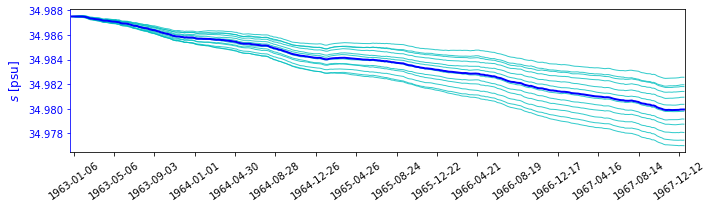

In [8]:
time = np.concatenate((np.concatenate((np.concatenate((np.concatenate((
                       np.arange('1963-01-01','1963-12-31',np.timedelta64(5,'D'),
                                 dtype='datetime64'),
                       np.arange('1964-01-01','1964-12-31',np.timedelta64(5,'D'),
                                 dtype='datetime64'))),
                       np.arange('1965-01-01','1965-12-31',np.timedelta64(5,'D'),
                                 dtype='datetime64'))),
                       np.arange('1966-01-01','1966-12-31',np.timedelta64(5,'D'),
                                 dtype='datetime64'))),
                       np.arange('1967-01-01','1967-12-31',np.timedelta64(5,'D'),
                                 dtype='datetime64'))
                     )

fig, ax = plt.subplots(figsize=(10,3))
fig.set_tight_layout(True)
# ax2 = ax.twinx()

for mm in range(len(HS.nmemb)):
    ax.plot(time, HS.isel(nmemb=mm).data, c='c', alpha=.8, lw=1)
#     ax2.plot(time, HT.isel(nmemb=mm).data, c='red', alpha=.5, lw=1)

ax.plot(time, HS.mean('nmemb').data, 'b', lw=2)
# ax2.plot(time, HT.mean('nmemb').data, 'r', lw=2)
    
ax.set_xticks(time[1::24])
ax.set_xticklabels(time[1::24], rotation=35)
ax.set_xlim(['1962-12-27','1967-12-31'])
# ax.set_ylim([0.0065,0.016])
ax.spines['left'].set_color('blue')
ax.set_ylabel(r"$s$ [psu]", fontsize=12, c='blue')
ax.tick_params(axis='y', colors='b')
# ax2.set_ylabel(r"$\theta$ [$^\circ$C]", fontsize=12, c='r')
# ax2.spines['right'].set_color('red')
# ax2.yaxis.label.set_color('red')
# ax2.tick_params(axis='y', colors='red')

# plt.savefig(op.join(savedir,'Figures/HKE-thetaAdjusted_1963-1967.pdf'))
plt.savefig(op.join(savedir,'Figures/Hsalt_adjusted_1963-1967.pdf'))

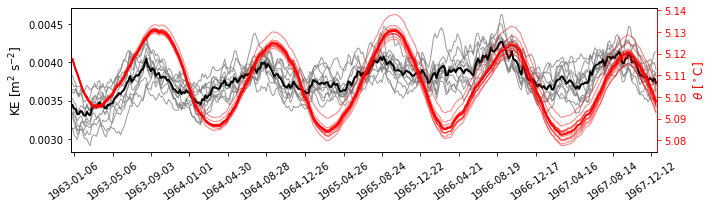

In [9]:
time = np.concatenate((np.concatenate((np.concatenate((np.concatenate((
                       np.arange('1963-01-01','1963-12-31',np.timedelta64(5,'D'),
                                 dtype='datetime64'),
                       np.arange('1964-01-01','1964-12-31',np.timedelta64(5,'D'),
                                 dtype='datetime64'))),
                       np.arange('1965-01-01','1965-12-31',np.timedelta64(5,'D'),
                                 dtype='datetime64'))),
                       np.arange('1966-01-01','1966-12-31',np.timedelta64(5,'D'),
                                 dtype='datetime64'))),
                       np.arange('1967-01-01','1967-12-31',np.timedelta64(5,'D'),
                                 dtype='datetime64'))
                     )

fig, ax = plt.subplots(figsize=(10,3))
fig.set_tight_layout(True)
ax2 = ax.twinx()

for mm in range(len(HT.nmemb)):
    ax.plot(time, HKE.isel(nmemb=mm).data, c='grey', alpha=.8, lw=1)
    ax2.plot(time, HT.isel(nmemb=mm).data, c='red', alpha=.5, lw=1)

ax.plot(time, HKE.mean('nmemb').data, 'k', lw=2)
ax2.plot(time, HT.mean('nmemb').data, 'r', lw=2)
    
ax.set_xticks(time[1::24])
ax.set_xticklabels(time[1::24], rotation=35)
ax.set_xlim(['1962-12-27','1967-12-31'])
# ax.set_ylim([0.0065,0.016])
ax.set_ylabel(r"KE [m$^2$ s$^{-2}$]", fontsize=12)
ax2.set_ylabel(r"$\theta$ [$^\circ$C]", fontsize=12, c='r')
ax2.spines['right'].set_color('red')
# ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')

# plt.savefig(op.join(savedir,'Figures/HKE-thetaAdjusted_1963-1967.pdf'))
plt.savefig(op.join(savedir,'Figures/HKE-thetaAdjusted_1963-1967.pdf'))

In [26]:
xchunk = 250
ychunk = 400
nmembs = range(24,36)
ystart = ySstart

for yy in range(1965,1968):
    for nmemb in nmembs:
        if nmemb == 24:
            dsnap = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                            % (nmemb,yy)), 
                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                    prefix=['diag_ocnSnap',
    #                                         'diag_Tbgt2D','diag_Tbgt3D',
    #                                         'diag_Sbgt2D','diag_Sbgt3D'
                                           ], delta_t=2e2,
    #                                 iters=range(943920-2160,943920+2160,2160),
    #                                 iters=943920, 
    #                                 chunks={'XC':xchunk,'XG':xchunk}
                                   ).chunk({'XC':xchunk,'XG':xchunk,
                                            'YC':ychunk,'YG':ychunk})
        else:
            dsnap = xr.concat([dsnap, 
                               open_mdsdataset(op.join(ddir,
                                                       'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                       % (nmemb,yy)), 
                                               grid_dir=op.join(ddir,
                                                                'grid_chaO/gridMIT_update1/'),
                                               prefix=['diag_ocnSnap',
#                                                        'diag_Tbgt2D','diag_Tbgt3D',
#                                                        'diag_Sbgt2D','diag_Sbgt3D'
                                                      ], delta_t=2e2,
#                                                iters=range(943920-2160,943920+2160,2160),
#                                                iters=943920, 
#                                                chunks={'XC':xchunk,'XG':xchunk}
                                              ).chunk({'XC':xchunk,'XG':xchunk,
                                                       'YC':ychunk,'YG':ychunk})],
                              dim='nmemb')
    dsnap.coords['nmemb'] = ('nmemb',range(12))
    dsnap = dsnap.chunk({'nmemb':1})
    
    dHT_0 = xr.open_dataset(op.join(savedir,'IC_temperature-bias_%2dS-%2dN.nc'
                                        % (np.abs(ystart),yend))).dHT0
    dHS_0 = xr.open_dataset(op.join(savedir,'IC_salinity-bias_%2dS-%2dN.nc'
                                        % (np.abs(ystart),yend))).dHS0
    
    theta = (dsnap.THETA - dHT_0).mean(['nmemb'], skipna=True)
    salt = (dsnap.SALT - dHS_0).mean(['nmemb'], skipna=True)
    
    rho = xr.apply_ufunc(densjmd95, 
                         salt.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                         theta.sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                         -grav*dsnap.Z*rhoConst*1e-4,             # pressure in [dbar]!!!!
                         dask='parallelized', output_dtypes=[float,]
                        ).where(dsnap.maskC!=0.)
    rho.to_dataset(name='rho').to_zarr(op.join(savedir,'%4d/rho_bar/' % (year)), mode='w')
    
    del rho
    dsnap.close()
    print(yy)

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option

ValueError: Zarr requires uniform chunk sizes except for final chunk. Variable dask chunks ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), (46,), (342, 400, 41), (250, 250, 250, 250)) are incompatible. Consider rechunking using `chunk()`.

In [7]:
rho = xr.open_zarr(op.join(savedir,'%4d/rho_bar/' % (1964))).rho
rho

<xarray.DataArray 'rho' (time: 73, Z: 46, YC: 783, XC: 1000)>
dask.array<zarr, shape=(73, 46, 783, 1000), dtype=float64, chunksize=(10, 6, 98, 125), chunktype=numpy.ndarray>
Coordinates:
    Depth    (YC, XC) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
    PHrefC   (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) float64 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
  * Z        (Z) float32 -3.0467727 -9.454049 ... -5624.9517 -5875.141
    drF      (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
    hFacC    (Z, YC, XC) float32 dask.array<chunksize=(6, 196, 250), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(12, 196, 250), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(392, 500), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(196, 500), meta=np.ndarray>
  * time     (time) timedelta64[ns] 2190 days 2195 days ... 2545 days 2550 days

<xarray.DataArray 'histogram_rho' (rho_bin: 39)>
dask.array<getitem, shape=(39,), dtype=int64, chunksize=(39,), chunktype=numpy.ndarray>
Coordinates:
  * rho_bin  (rho_bin) float64 1.02e+03 1.021e+03 ... 1.054e+03 1.055e+03

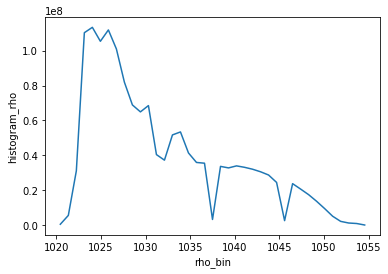

In [10]:
rho.name = 'rho'

bins = np.linspace(1020, 1055, 40)
h = xhist(rho, bins=[bins])
display(h)
h.plot()

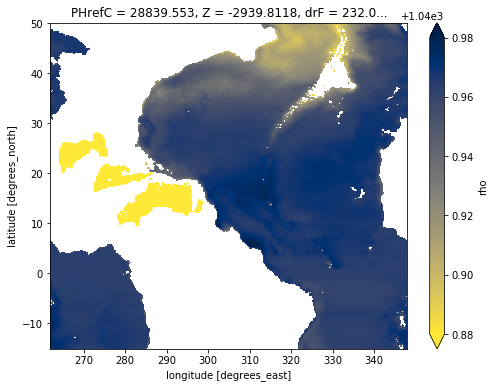

In [18]:
rho.mean('time').sel(Z=-3000,
                     method='nearest').plot(figsize=(8,6), cmap='cividis_r', 
                                            vmin=1040.88, vmax=1040.98, 
                                            rasterized=True)

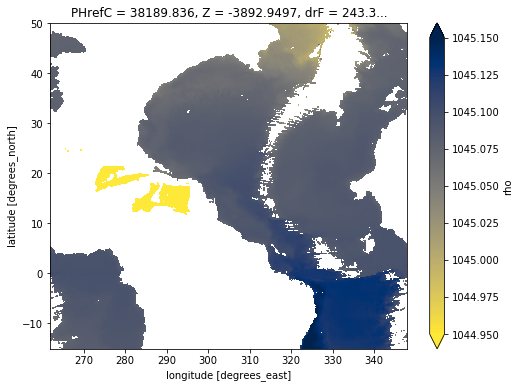

In [25]:
rho.mean('time').sel(Z=-4000,
                     method='nearest').plot(figsize=(8,6), cmap='cividis_r', 
                                            vmin=1044.95, vmax=1045.15, 
                                            rasterized=True)

In [9]:
# Vol_r = ds.rA**-1 * ds.drF**-1 * ds.hFacC**-1
# xA = ds.hFacW * ds.dyG * ds.drF
# yA = ds.hFacS * ds.dxG * ds.drF
# dxC_r = ds.dxC**-1
# dyC_r = ds.dyC**-1
# dxG_r = ds.dxG**-1
# dyG_r = ds.dyG**-1
# rA_r = ds.rA**-1
fG = xr.apply_ufunc(gsw.f, dsnap.YG, dask='parallelized')
fC = xr.apply_ufunc(gsw.f, dsnap.YC, dask='parallelized')round

In [10]:
rho_snap = xr.apply_ufunc(jmd95.densjmd95, dsnap.SALT, dsnap.THETA,
                          (dsnap.PHIHYD-grav*dsnap.Z)*rhoConst*1e-4, # pressure in [dbar]!!!!
                          dask='parallelized', output_dtypes=[float,]
                         ).where(dsnap.maskC!=0.)
rho_snapx = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsnap.SALT,'X'), 
                           grid.interp(dsnap.THETA,'X'), 
                           grid.interp((dsnap.PHIHYD-grav*dsnap.Z)*rhoConst*1e-4,'X'), 
                           dask='parallelized', output_dtypes=[float,]
                          ).where(dsnap.maskW!=0.)
rho_snapy = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsnap.SALT,'Y',boundary='fill'), 
                           grid.interp(dsnap.THETA,'Y',boundary='fill'), 
                           grid.interp((dsnap.PHIHYD-grav*dsnap.Z)*rhoConst*1e-4,
                                       'Y',boundary='fill'),
                           dask='parallelized', output_dtypes=[float,]
                          ).where(dsnap.maskS!=0.)
# rhoz = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsocn.SALT,'Z',boundary='fill'), 
#                       grid.interp(dsocn.THETA,'Z',boundary='fill'), 
#                       grid.interp((dsocn.PHIHYD-grav*dsocn.Z)*rhoConst*1e-4,'Z',boundary='fill'),
#                       dask='parallelized', output_dtypes=[float]
#                      ).where(dsocn.maskInS!=0.)
rho_snap

<xarray.DataArray (nmemb: 6, Z: 46, YC: 900, XC: 1000)>
dask.array<where, shape=(6, 46, 900, 1000), dtype=float64, chunksize=(1, 46, 900, 250), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 250), meta=np.ndarray>
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    time     float64 1.888e+08
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    rA       (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
Dimensions without coordinates: nmemb

In [15]:
buoy = -grav * (rho_snap - rhoConst) * rhoConst**-1
# m = ds.PHIHYD.where(ds.maskC!=0.) - buoy*ds.Z

##################
dbdx = (grid.diff(buoy * grid.interp(dsnap.dyG,'X'),
                  'X'
                 ) * dsnap.rAw**-1
       ).where(dsnap.maskW!=0.)
dbdy = (grid.diff(buoy * grid.interp(dsnap.dxG,'Y',boundary='fill'),
                  'Y',boundary='fill'
                 ) * dsnap.rAs**-1
       ).where(dsnap.maskS!=0.)
##################
dpdx_snap = (grid.diff(dsnap.PHIHYD.where(dsnap.maskC!=0.) 
                       * grid.interp(dsnap.dyG,'X'),'X'
                      ) * dsnap.rAw**-1
            ).where(dsnap.maskW!=0.)
dpdy_snap = (grid.diff(dsnap.PHIHYD.where(dsnap.maskC!=0.) 
                       * grid.interp(dsnap.dxG,'Y',boundary='fill'),
                       'Y',boundary='fill'
                      ) * dsnap.rAs**-1
            ).where(dsnap.maskS!=0.)

In [17]:
# DiffE = - (-grid.diff(ds.DFrE_TH,'Z',boundary='fill') * Vol_r
#            + grid.diff(ds.DFxE_TH,'X') * Vol_r
#            + grid.diff(ds.DFyE_TH,'Y',boundary='fill') * Vol_r
#           ).where(ds.maskC!=0.)
# DiffI = (grid.diff(ds.DFrI_TH,'Z',boundary='fill') * Vol_r).where(ds.maskC!=0.)
# Kpp = grid.diff(ds.KPPg_TH.where(ds.maskInC!=0.),'Z',boundary='fill') * Vol_r
swfrac = .62 * np.exp(dsnap.Zl/.6) + (1-.62) * np.exp(dsnap.Zl/20.)
swfrac1 = .62 * np.exp(dsnap.Zl.shift(Zl=-1)/.6) + (1-.62) * np.exp(dsnap.Zl.shift(Zl=-1)/20.)
Qsw = (dsnap.oceQsw / (rhoConst*Cp) / (dsnap.drF*dsnap.hFacC) 
       * (swfrac - swfrac1).data
      ).where(dsnap.maskC!=0.)
Tflx = ((dsnap.TFLUX - dsnap.oceQsw)
        / (rhoConst*Cp*dsnap.drF[0]*dsnap.hFacC.isel(Z=0))
       ).where(dsnap.maskInC!=0.)
tsurf_corr = 0.                  # linFSConverveTr = F.
Surf_corr = (tsurf_corr - dsnap.WTHMASS[:,0].where(dsnap.maskInC!=0.)
            ) / (dsnap.drF[0]*dsnap.hFacC.isel(Z=0))
# print(xr.DataArray((Tflx+Surf_corr).data.reshape((len(ds.nmemb),1,len(ds.YC),len(ds.XC))),
#                    dims=['nmemb','Z','YC','XC'],
#                    coords={'nmemb':ds.nmemb.data,'Z':np.array([ds.Z[0].data]),
#                            'YC':ds.YC.data,'XC':ds.XC.data}))
# DibaT = (ds.Diss_TH.where(ds.maskC!=0.) + Qsw).load()
# DibaT.isel(Z=0)[:] += (Tflx + Surf_corr).load()
DibaT = dsnap.Diss_TH.where(dsnap.maskC!=0.) + Qsw
DibaT = DibaT + xr.DataArray((Tflx+Surf_corr).data.reshape((len(dsnap.nmemb),1,
                                                            len(dsnap.YC),len(dsnap.XC))),
                             dims=['nmemb','Z','YC','XC'],
                             coords={'nmemb':dsnap.nmemb.data,'Z':np.array([dsnap.Z[0].data]),
                                     'YC':dsnap.YC.data,'XC':dsnap.XC.data}
                            )
# DibaT

# ##################
# DiffE = - (-grid.diff(ds.DFrE_SLT,'Z',boundary='fill') * Vol_r
#            + grid.diff(ds.DFxE_SLT,'X') * Vol_r
#            + grid.diff(ds.DFyE_SLT,'Y',boundary='fill') * Vol_r
#           ).where(ds.maskC!=0.)
# DiffI = (grid.diff(ds.DFrI_SLT,'Z',boundary='fill') * Vol_r).where(ds.maskC!=0.)
# Kpp = grid.diff(ds.KPPg_SLT.where(ds.maskInC!=0.),'Z',boundary='fill') * Vol_r
Sflx = (dsnap.SFLUX
        / (rhoConst*dsnap.drF[0]*dsnap.hFacC.isel(Z=0))
       ).where(dsnap.maskInC!=0.)
ssurf_corr = 0.                  # linFSConverveTr = F.
Surf_corr = (ssurf_corr - dsnap.WSLTMASS[:,0].where(dsnap.maskInC!=0.)
            ) / (dsnap.drF[0]*dsnap.hFacC.isel(Z=0))
DibaS = dsnap.Diss_SLT.where(dsnap.maskC!=0.)
# DibaS.isel(Z=0)[:] += (Sflx + Surf_corr).load()
DibaS = DibaS + xr.DataArray((Sflx+Surf_corr).data.reshape((len(dsnap.nmemb),1,
                                                            len(dsnap.YC),len(dsnap.XC))),
                             dims=['nmemb','Z','YC','XC'],
                             coords={'nmemb':dsnap.nmemb.data,'Z':np.array([dsnap.Z[0].data]),
                                     'YC':dsnap.YC.data,'XC':dsnap.XC.data}
                            )

## $${\bf E} \simeq \left(\begin{array}{ccc} 
\overline{u'u'} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2} & \overline{v'u'} & 0 \\
\overline{u'v'} & \overline{v'v'} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2} & 0 \\
\overline{\varpi'u'} + \frac{1}{\overline{\sigma}}\overline{\zeta'm_x'} & \overline{\varpi'v'} + \frac{1}{\overline{\sigma}}\overline{\zeta'm_y'} & 0
\end{array}\right)
$$

where
$$\varpi \equiv \kappa\nabla^2 b = \kappa \Big[\frac{\partial b}{\partial \theta} (\nabla^2 \theta) + \frac{\partial b}{\partial s} (\nabla^2 s)\Big].$$

In [11]:
up = dsnap.UVEL - dsbar.UVEL
vp = dsnap.VVEL - dsbar.VVEL
up2bar = (up**2).mean('nmemb')
vp2bar = (vp**2).mean('nmemb')
vpupbar = (grid.interp(grid.interp(vp,'X'),'Y',boundary='fill') 
           * up).mean('nmemb')
upvpbar = (grid.interp(grid.interp(up,'X'),'Y',boundary='fill') 
           * vp).mean('nmemb')
vpupbar

<xarray.DataArray (Z: 46, YC: 900, XG: 1000)>
dask.array<mean_agg-aggregate, shape=(46, 900, 1000), dtype=float32, chunksize=(46, 899, 249), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    rAw      (YC, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    dxC      (YC, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    hFacW    (Z, YC, XG) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    dyG      (YC, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    time     float64 1.888e+08
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(900, 250), meta=np.ndarray>

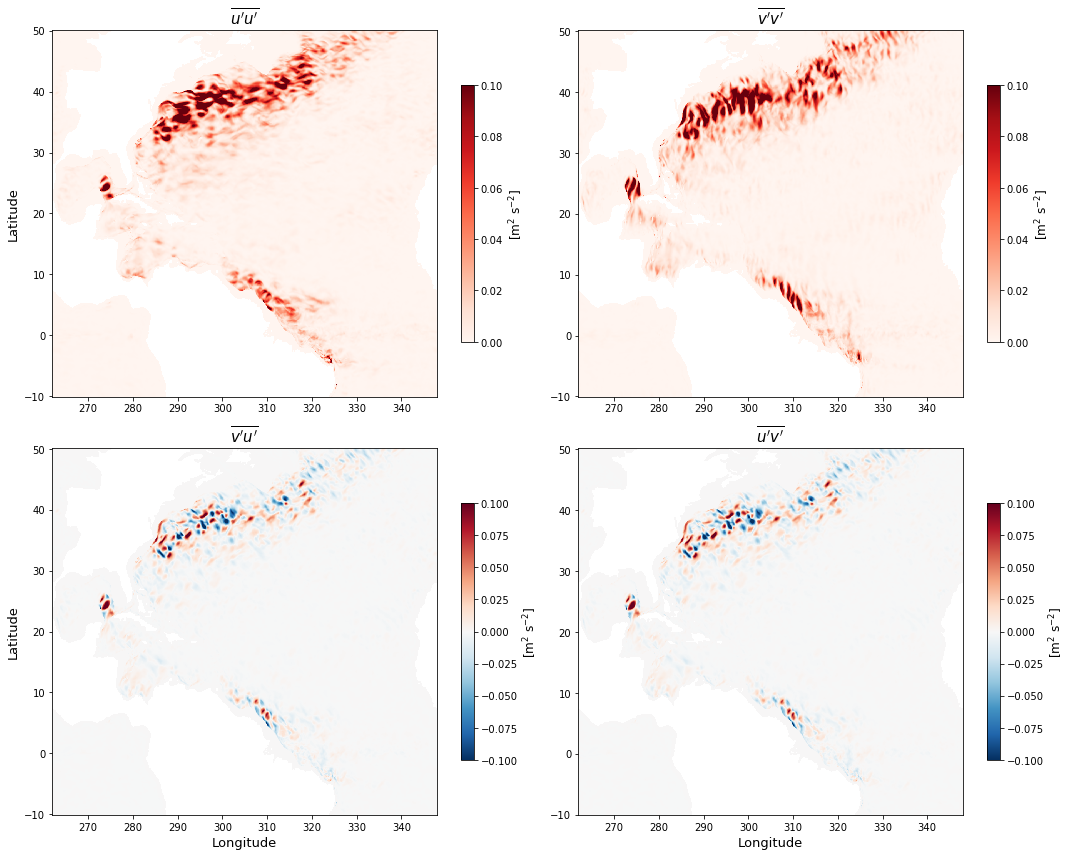

In [12]:
fig, axes = plt.subplots(figsize=(15,12), nrows=2, ncols=2)
fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(up.XG, up.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                           up2bar.sel(Z=-300,method='nearest'
                                     ).where(dsnap.maskInW!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)),
                           vmin=0., vmax=.1e0, cmap='Reds', rasterized=True)
im1 = axes[0,1].pcolormesh(vp.XC, vp.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)), 
                           vp2bar.sel(Z=-300,method='nearest'
                                     ).where(dsnap.maskInS!=0.).sel(YG=slice(ystart-12**-1,
                                                                             yend+2*12**-1)),
                           vmin=0., vmax=.1e0, cmap='Reds', rasterized=True)
im2 = axes[1,0].pcolormesh(up.XG, up.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                           vpupbar.sel(Z=-300,method='nearest'
                                      ).where(dsnap.maskInW!=0.).sel(YC=slice(ystart-12**-1,
                                                                              yend+2*12**-1)), 
                           vmin=-.1e0, vmax=.1e0, cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(vp.XC, vp.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)), 
                           upvpbar.sel(Z=-300,method='nearest'
                                      ).where(dsnap.maskInS!=0.).sel(YG=slice(ystart-12**-1,
                                                                              yend+2*12**-1)), 
                           vmin=-.1e0, vmax=.1e0, cmap='RdBu_r', rasterized=True)
# vpp[:,:,:,25].mean(['nmemb']).plot(ax=axes[0,1], vmin=-.5e-2, vmax=.5e-2, cmap='RdBu_r')
# (zetap)[:,:,:,25].mean(['nmemb']).where(ds.maskInC!=0.).plot(ax=axes[1,0], vmin=-1e-11, vmax=1e-11, 
#                                                              cmap='RdBu_r')
# varpipp[:,:,:,25].mean(['nmemb']).where(ds.maskInC!=0.).plot(ax=axes[1,1], vmax=1e-9, vmin=-1e-9, 
#                                                              cmap='RdBu_r')

axes[0,0].set_title(r"$\overline{u'u'}$", fontsize=15)
axes[0,1].set_title(r"$\overline{v'v'}$", fontsize=15)
axes[1,0].set_title(r"$\overline{v'u'}$", fontsize=15)
axes[1,1].set_title(r"$\overline{u'v'}$", fontsize=15)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

cbar0 = fig.colorbar(im0, ax=axes[0,0], shrink=.7)
cbar0.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar1 = fig.colorbar(im1, ax=axes[0,1], shrink=.7)
cbar1.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[1,0], shrink=.7)
cbar2.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.7)
cbar3.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)

plt.savefig(op.join(savedir,'Figures/Cartesian-Reynoldsfluxes_1963-Dec-26.pdf'))

In [14]:
up2x = grid.diff(up2bar*dsnap.dyG, 'X') * dsnap.rA**-1
upvpy = grid.diff(upvpbar*dsnap.dxG, 'Y', boundary='fill') * dsnap.rA**-1

vpupx = grid.diff(vpupbar*dsnap.dyG, 'X') * dsnap.rA**-1 
vp2y = grid.diff(vp2bar*dsnap.dxG, 'Y', boundary='fill') * dsnap.rA**-1 

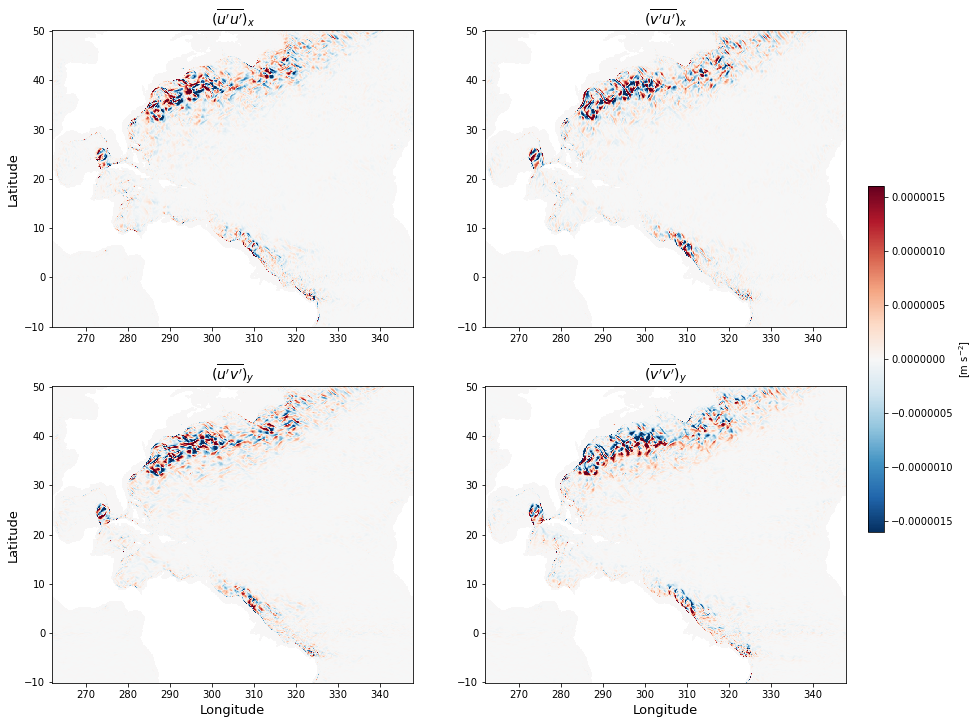

In [19]:
fig, axes = plt.subplots(figsize=(15,12), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(up2x.XC, up2x.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                          up2x.sel(Z=-300,
                                   method='nearest').where(dsnap.maskInC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                           yend+2*12**-1)), 
                          vmax=1.6e-6, vmin=-1.6e-6, cmap='RdBu_r', rasterized=True)
axes[1,0].pcolormesh(upvpy.XC, upvpy.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                     upvpy.sel(Z=-300,
                               method='nearest').where(dsnap.maskInC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                       yend+2*12**-1)), 
                     vmax=1.6e-6, vmin=-1.6e-6, cmap='RdBu_r', rasterized=True)
axes[0,1].pcolormesh(vpupx.XC, vpupx.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                     vpupx.sel(Z=-300,
                               method='nearest').where(dsnap.maskInC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                       yend+2*12**-1)), 
                     vmax=1.6e-6, vmin=-1.6e-6, cmap='RdBu_r', rasterized=True)
axes[1,1].pcolormesh(vp2y.XC, vp2y.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                     vp2y.sel(Z=-300,
                              method='nearest').where(dsnap.maskInC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                      yend+2*12**-1)), 
                     vmax=1.6e-6, vmin=-1.6e-6, cmap='RdBu_r', rasterized=True)

axes[0,0].set_title(r"$(\overline{u'u'})_x$", fontsize=14)
axes[1,0].set_title(r"$(\overline{u'v'})_y$", fontsize=14)
axes[0,1].set_title(r"$(\overline{v'u'})_x$", fontsize=14)
axes[1,1].set_title(r"$(\overline{v'v'})_y$", fontsize=14)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86)
# cbaxes = fig.add_axes([0.2, 0.08, 0.6, 0.01]) 
cbaxes = fig.add_axes([0.88, 0.3, 0.015, 0.4]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
cbar.set_label(r"[m s$^{-2}$]")

plt.savefig(op.join(savedir,'Figures/Div_Cartesian-Reynoldsflux_1963-Dec-26.pdf'))

In [54]:
dvdx = grids.diff(vdz*dzetaFy**-1*ds.dyC,'X') * ds.rAz**-1
dudy = grids.diff(udz*dzetaFx**-1*ds.dxC,'Y',boundary='fill') * ds.rAz**-1
Pi = (grids.interp(grids.interp((1. + (dvdx - dudy)*fG**-1),'X'),
                   'Y',boundary='fill') * sigma**-1).mean('nmemb')
Pi

<xarray.DataArray (YC: 723, XC: 1000, sig: 81)>
dask.array<mean_agg-aggregate, shape=(723, 1000, 81), dtype=float64, chunksize=(721, 498, 1), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.38 20.75 21.12 ... 48.88 49.25 49.62 50.0

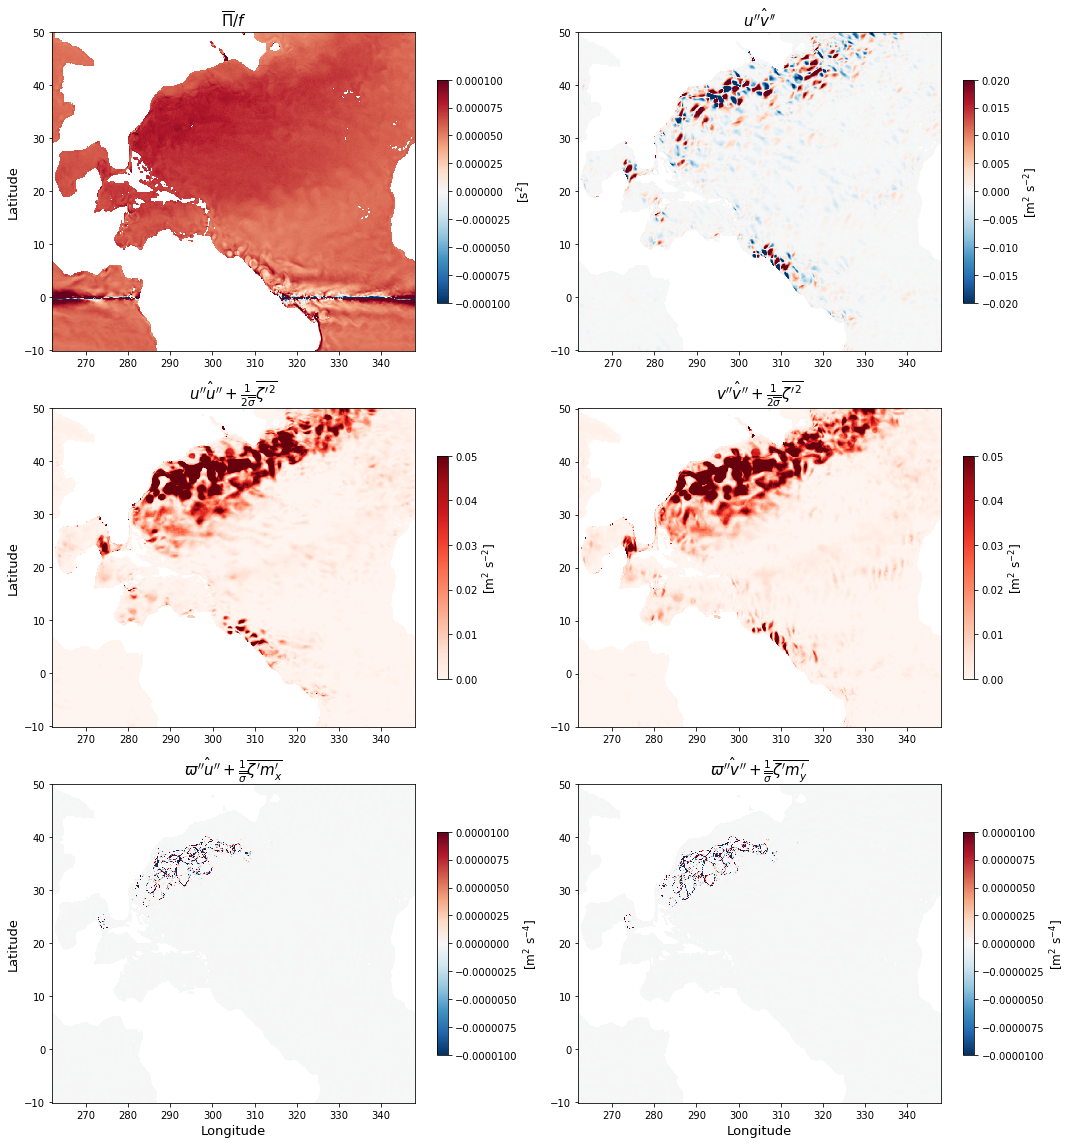

In [77]:
fig, axes = plt.subplots(figsize=(15,16), nrows=3, ncols=2)
fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(Pi.XC, Pi.YC, Pi[:,:,25], 
                           vmin=-1e-4, vmax=1e-4, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(e00.XG, e00.YC, e00[:,:,25], vmax=5e-2, vmin=0, cmap='Reds', rasterized=True)
im1 = axes[0,1].pcolormesh(e01.XG, e01.YC, e01[:,:,25], vmax=2e-2, vmin=-2e-2, cmap='RdBu_r', rasterized=True)
# e10[:,:,25].plot(ax=axes[1,0], vmax=2e-2, vmin=-2e-2, cmap='RdBu_r', rasterized=True)
im3 = axes[1,1].pcolormesh(e11.XC, e11.YG, e11[:,:,25], vmax=5e-2, vmin=0, cmap='Reds', rasterized=True)
im4 = axes[2,0].pcolormesh(e20.XC, e20.YC, e20[:,:,25], vmax=1e-5, vmin=-1e-5, cmap='RdBu_r', rasterized=True)
im5 = axes[2,1].pcolormesh(e21.XC, e21.YC, e21[:,:,25], vmax=1e-5, vmin=-1e-5, cmap='RdBu_r', rasterized=True)

axes[1,0].set_title(r"$\hat{u''u''} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2}$", fontsize=15)
axes[0,1].set_title(r"$\hat{u''v''}$", fontsize=15)
# axes[1,0].set_title(r"$\hat{v''u''}$", fontsize=15)
axes[0,0].set_title(r"$\overline{\Pi}/f$", fontsize=15)
axes[1,1].set_title(r"$\hat{v''v''} + \frac{1}{2\overline{\sigma}}\overline{\zeta'^2}$", fontsize=15)
axes[2,0].set_title(r"$\hat{\varpi''u''} + \frac{1}{\overline{\sigma}}\overline{\zeta'm_x'}$", fontsize=15)
axes[2,1].set_title(r"$\hat{\varpi''v''} + \frac{1}{\overline{\sigma}}\overline{\zeta'm_y'}$", fontsize=15)
axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

cbar0 = fig.colorbar(im0, ax=axes[0,0], shrink=.7)
cbar0.set_label(r"[s$^2$]", fontsize=12)
cbar1 = fig.colorbar(im1, ax=axes[0,1], shrink=.7)
cbar1.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[1,0], shrink=.7)
cbar2.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.7)
cbar3.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar4 = fig.colorbar(im4, ax=axes[2,0], shrink=.7)
cbar4.set_label(r"[m$^2$ s$^{-4}$]", fontsize=12)
cbar5 = fig.colorbar(im5, ax=axes[2,1], shrink=.7)
cbar5.set_label(r"[m$^2$ s$^{-4}$]", fontsize=12)

plt.savefig(op.join(savedir,'Figures/E-P_flux_1963-Dec-26.pdf'))

## Divergence of the E-P flux tensor
#### $$\mathbf{e}_1\cdot(\nabla\cdot{\bf E}) = \overline{\sigma}^{-1}\Big[\partial_\tilde{x}\big[\overline{\sigma}\widehat{u"u"} + \frac{1}{2}\overline{\zeta'^2}\big] + \partial_\tilde{y}(\overline{\sigma}\widehat{u"v"}) + \partial_\tilde{b}\big[\overline{\sigma}\widehat{\varpi''u''} + \overline{\zeta'm_x'}\big]\Big]$$
#### $$\mathbf{e}_2\cdot(\nabla\cdot{\bf E}) = \overline{\sigma}^{-1}\Big[\partial_\tilde{x}(\overline{\sigma}\widehat{v"u"}) + \partial_\tilde{y}\big[\overline{\sigma}\widehat{v"v"} + \frac{1}{2}\overline{\zeta'^2}\big] + \partial_\tilde{b}\big[\overline{\sigma}\widehat{\varpi''v''} + \overline{\zeta'm_y'}\big]\Big]$$

In [57]:
e00x = grids.diff(sigmax.mean('nmemb')*e00*ds.dyG,'X') * ds.rA**-1 * sigma.mean('nmemb')**-1
e10y = grids.diff(sigmay.mean('nmemb')*e10*ds.dxG,'Y',boundary='fill') * ds.rA**-1 * sigma.mean('nmemb')**-1
e20b = grids.interp(grids.diff(sigma.mean('nmemb')*e20,'Z',boundary='fill') 
                    * grids.diff(buoyb,'Z',boundary='fill')**-1,
                    'Z',boundary='fill') * sigma.mean('nmemb')**-1
e01x = grids.diff(sigmax.mean('nmemb')*e01*ds.dyG,'X') * ds.rA**-1 * sigma.mean('nmemb')**-1
e11y = grids.diff(sigmay.mean('nmemb')*e11*ds.dxG,'Y',boundary='fill') * ds.rA**-1 * sigma.mean('nmemb')**-1
e21b = grids.interp(grids.diff(sigma.mean('nmemb')*e21,'Z',boundary='fill') 
                    * grids.diff(buoyb,'Z',boundary='fill')**-1,
                    'Z',boundary='fill') * sigma.mean('nmemb')**-1
print(e00x,e10y,e20b,e01x,e11y,e21b)

<xarray.DataArray (YC: 723, XC: 1000, sig: 81)>
dask.array<mul, shape=(723, 1000, 81), dtype=float64, chunksize=(723, 499, 1), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 -10.08 -10.0 -9.917 -9.833 ... 49.83 49.92 50.0 50.08
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.38 20.75 21.12 ... 48.88 49.25 49.62 50.0
    rA       (YC, XC) >f4 dask.array<chunksize=(723, 500), meta=np.ndarray>
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(723, 500), meta=np.ndarray>
    time     float64 1.888e+08
    maskInC  (YC, XC) bool dask.array<chunksize=(723, 500), meta=np.ndarray> <xarray.DataArray (YC: 723, XC: 1000, sig: 81)>
dask.array<mul, shape=(723, 1000, 81), dtype=float64, chunksize=(721, 500, 1), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 -10.08 -10.0 -9.917 -9.833 ... 49.83 49.92 50.0 50.08
  * XC       (XC) >f4 262.00003 262.08

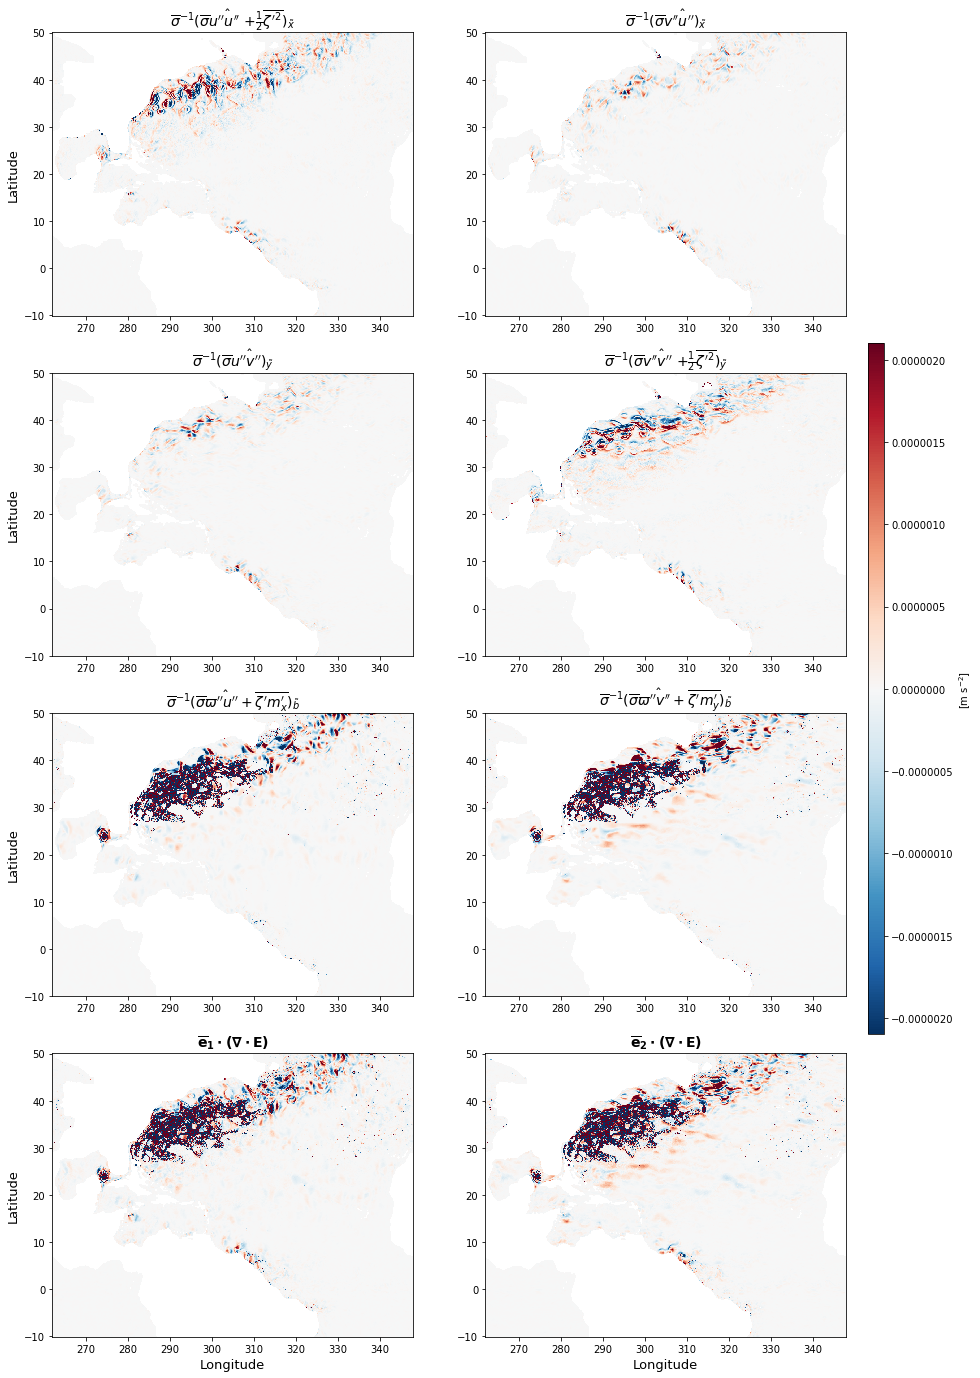

In [62]:
fig, axes = plt.subplots(figsize=(15,24), nrows=4, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(e00x.XC, e00x.YC, e00x[:,:,25], vmax=2.1e-6, vmin=-2.1e-6, 
                          cmap='RdBu_r', rasterized=True)
axes[1,0].pcolormesh(e10y.XC, e10y.YC, e10y[:,:,25], vmax=2.1e-6, vmin=-2.1e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[0,1].pcolormesh(e01x.XC, e01x.YC, e01x[:,:,25], vmax=2.1e-6, vmin=-2.1e-6, 
                     cmap='RdBu_r', rasterized=True)
# (zdz*dzetaF**-1).mean('nmemb')[:,:,25].plot(ax=axes[0,0], vmin=-6e2, vmax=-3e2, cmap='Blues_r', rasterized=True)
axes[1,1].pcolormesh(e11y.XC, e11y.YC, e11y[:,:,25], vmax=2.1e-6, vmin=-2.1e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[2,0].pcolormesh(e20b.XC, e20b.YC, e20b[:,:,25], vmax=2.1e-6, vmin=-2.1e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[2,1].pcolormesh(e21b.XC, e21b.YC, e21b[:,:,25], vmax=2.1e-6, vmin=-2.1e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[3,0].pcolormesh(e00x.XC, e00x.YC, (e00x+e10y+e20b)[:,:,25], vmax=2.1e-6, vmin=-2.1e-6, 
                     cmap='RdBu_r', rasterized=True)
axes[3,1].pcolormesh(e01x.XC, e01x.YC, (e01x+e11y+e21b)[:,:,25], vmax=2.1e-6, vmin=-2.1e-6, 
                     cmap='RdBu_r', rasterized=True)

axes[0,0].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{u''u''}$ "
                    + r"$+ \frac{1}{2}\overline{\zeta'^2})_\tilde{x}$", 
                    fontsize=14)
axes[1,0].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{u''v''})_\tilde{y}$", fontsize=14)
axes[0,1].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{v''u''})_\tilde{x}$", fontsize=14)
# axes[0,0].set_title(r"$\overline{\zeta}$", fontsize=15)
axes[1,1].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{v''v''}$ "
                    + r"$+ \frac{1}{2}\overline{\zeta'^2})_\tilde{y}$", 
                    fontsize=14)
axes[2,0].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{\varpi''u''} + \overline{\zeta'm_x'})_\tilde{b}$", 
                    fontsize=14)
axes[2,1].set_title(r"$\overline{\sigma}^{-1}(\overline{\sigma}\hat{\varpi''v''} + \overline{\zeta'm_y'})_\tilde{b}$", 
                    fontsize=14)
axes[3,0].set_title(r"$\overline{\bf e}_1\cdot(\nabla\cdot{\bf E})$", fontsize=14)
axes[3,1].set_title(r"$\overline{\bf e}_2\cdot(\nabla\cdot{\bf E})$", fontsize=14)

axes[3,0].set_xlabel(r"Longitude", fontsize=13)
axes[3,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)
axes[3,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86)
# cbaxes = fig.add_axes([0.2, 0.08, 0.6, 0.01]) 
cbaxes = fig.add_axes([0.88, 0.3, 0.015, 0.4]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
cbar.set_label(r"[m s$^{-2}$]")

plt.savefig(op.join(savedir,'Figures/Div_E-P_flux_1963-Dec-26.pdf'))